## Sports Image Classification Project

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

#### Dataset

In [48]:
sports = pd.read_csv("data/sports.csv")
sports

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


##### Data Directories for Training, Testing, and Validating

In [49]:
train_dir = "./data/train/"
test_dir = "./data/test/"
val_dir = './data/valid/'

##### Function for Displaying Random Images with Thier Given Labels

In [50]:
def random_images_labels(folder, images):
    #Getting Subfolders
    subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
    
    fig, axes = plt.subplots(nrows=1, ncols=images, figsize=(15, 5))
    for i, subfolders in enumerate(subfolders[:images]):
        image_paths = [os.path.join(subfolders, f) for f in os.listdir(subfolders) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(image_paths)
        image_path = image_paths[0] #Indexing to the first shuffled image
        
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolders)})", fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

##### Testing that the Function is Working

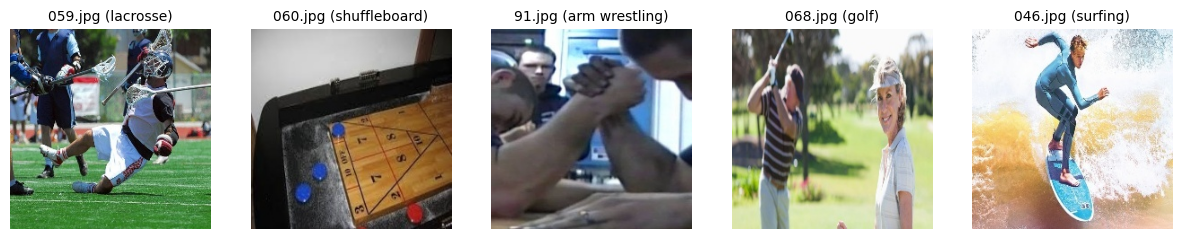

In [51]:
random_images_labels(train_dir, 5)

##### Image Data Generator

In [52]:
train_dg = ImageDataGenerator( zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2)

train_data_generator = test_dg.flow_from_directory(train_dir, class_mode="categorical", target_size=(299, 299), batch_size=128, shuffle=True)

NameError: name 'test_dg' is not defined

In [ ]:
val = ImageDataGenerator()

validate_data_generator = val.flow_from_directory(val_dir, class_mode="categorical", target_size=(299, 299), batch_size=128, shuffle=False)

Found 500 images belonging to 100 classes.


In [ ]:
test_data_generator = val.flow_from_directory(test_dir, class_mode="categorical",target_size = (299, 299), batch_size = 128, shuffle = False)

Found 500 images belonging to 100 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

In [56]:
base = EfficientNetB0(weights="efficientnetb0_notop.h5", include_top=False, input_shape=(299, 299, 3))
base

<Functional name=efficientnetb0, built=True>

In [58]:
for layers in base.layers:
    layers.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)

predictions = Dense(100, activation="softmax")(x)

model = Model(inputs=base.input, outputs=predictions)

In [60]:
opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [62]:
hist = model.fit(
    train_data_generator, 
    epochs =30, 
    validation_data = validate_data_generator,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-24 15:33:32.701128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-24 15:33:43.610020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-24 15:33:51.247623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 1082s 10s/step - accuracy: 0.4386 - loss: 2.5180 - val_accuracy: 0.8860 - val_loss: 0.4009 - learning_rate: 0.0050
Epoch 2/30


2024-06-24 15:51:16.880554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-24 15:51:26.883757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-24 15:51:33.584918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 938s 9s/step - accuracy: 0.8051 - loss: 0.7334 - val_accuracy: 0.9260 - val_loss: 0.2740 - learning_rate: 0.0050
Epoch 3/30


2024-06-24 16:06:55.923217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 16:07:03.286355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 920s 9s/step - accuracy: 0.8523 - loss: 0.5574 - val_accuracy: 0.9300 - val_loss: 0.2319 - learning_rate: 0.0050
Epoch 4/30


2024-06-24 16:22:17.091928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 16:22:24.357856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 879s 8s/step - accuracy: 0.8707 - loss: 0.4657 - val_accuracy: 0.9360 - val_loss: 0.2007 - learning_rate: 0.0050
Epoch 5/30


2024-06-24 16:36:54.898582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-06-24 16:37:05.022471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 981s 9s/step - accuracy: 0.8866 - loss: 0.4082 - val_accuracy: 0.9300 - val_loss: 0.1989 - learning_rate: 0.0050
Epoch 6/30


2024-06-24 16:53:16.529664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 16:53:23.859990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 853s 8s/step - accuracy: 0.8793 - loss: 0.3989 - val_accuracy: 0.9480 - val_loss: 0.1776 - learning_rate: 0.0050
Epoch 7/30


2024-06-24 17:07:26.823599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-06-24 17:07:36.806128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 872s 8s/step - accuracy: 0.9021 - loss: 0.3362 - val_accuracy: 0.9500 - val_loss: 0.1799 - learning_rate: 0.0050
Epoch 8/30


2024-06-24 17:22:01.428917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 17:22:08.879125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 824s 8s/step - accuracy: 0.9058 - loss: 0.3211 - val_accuracy: 0.9380 - val_loss: 0.1821 - learning_rate: 0.0050
Epoch 9/30


2024-06-24 17:35:45.504337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 17:35:52.913500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 865s 8s/step - accuracy: 0.9216 - loss: 0.2733 - val_accuracy: 0.9500 - val_loss: 0.1505 - learning_rate: 1.0000e-03
Epoch 10/30


2024-06-24 17:50:10.264556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 17:50:17.713405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 846s 8s/step - accuracy: 0.9286 - loss: 0.2543 - val_accuracy: 0.9500 - val_loss: 0.1576 - learning_rate: 1.0000e-03
Epoch 11/30


2024-06-24 18:04:16.750375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-24 18:04:24.226206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 854s 8s/step - accuracy: 0.9290 - loss: 0.2474 - val_accuracy: 0.9460 - val_loss: 0.1555 - learning_rate: 1.0000e-03
Epoch 12/30


2024-06-24 18:18:27.941715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-06-24 18:18:37.891219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


106/106 ━━━━━━━━━━━━━━━━━━━━ 914s 8s/step - accuracy: 0.9375 - loss: 0.2377 - val_accuracy: 0.9500 - val_loss: 0.1528 - learning_rate: 2.0000e-04


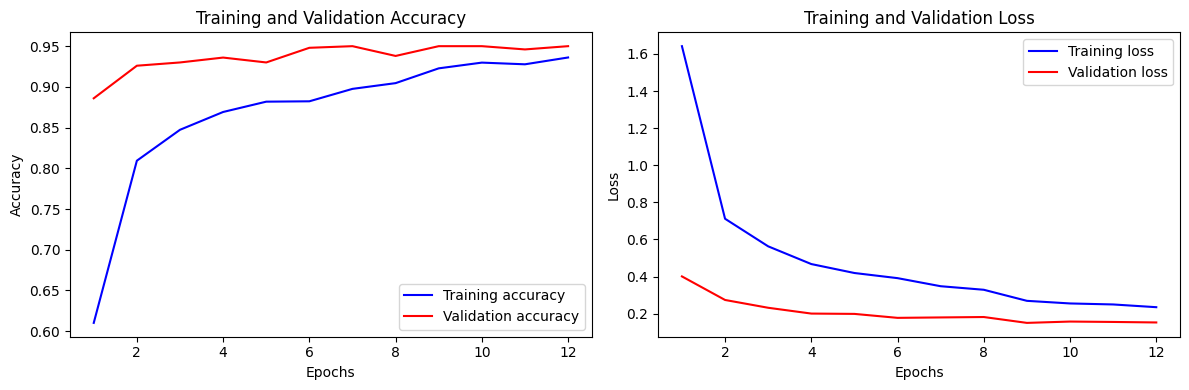

In [64]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

    # Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')    
plt.xlabel('Epochs')
plt.ylabel('Loss')    
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
predictions = model.evaluate(test_data_generator)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9600 - loss: 0.1647


In [70]:
labels = test_data_generator.classes

predicted_labels = np.argmax(model.predict(test_data_generator), axis = 1)

print("Classification Report:\n", classification_report(labels, predicted_labels, target_names=test_data_generator.class_indices.keys()))


4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step
Classification Report:
                        precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.80      0.80      0.80         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.83      1.00      0.91         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       0.83      1.00      0.91   